<a href="https://colab.research.google.com/github/MiguelCabreraVictoria/Modelo_Clasificador/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center;">
  <a href="https://th.bing.com/th/id/OIP.M3ZVpTqlXWAamrQLLuXSpQHaB9?rs=1&pid=ImgDetMain">
    <img src="https://th.bing.com/th/id/OIP.M3ZVpTqlXWAamrQLLuXSpQHaB9?rs=1&pid=ImgDetMain" alt="Texto alternativo" style="width:300px;">
  </a>
</div>


<h2><b>Nombre: </b> Miguel Angel Cabrera Victoria
<h3><b>Matricula: </b> A01782982
<h3><b>Fecha: </b> 12 de Septiembre del 2024

In [385]:
"Liberia y Configuracion Google Colab "
from google.colab import drive
drive.mount('/content/drive')

"Librerias basicas / Visualizacion"
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter

"Librerias de Mechine Learning"
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold


"""
Constantes
"""
DATA_TRAIN_PATH = "/content/drive/MyDrive/Tec/Septimo Semestre/Inteligencia artificial avanzada para la ciencia de datos/Evidencias/DataSet/training_data"
DATA_TEST_PATH = "/content/drive/MyDrive/Tec/Septimo Semestre/Inteligencia artificial avanzada para la ciencia de datos/Evidencias/DataSet/test_data"

MAPEO_ETIQUETAS = {'carros': 'carro',
                     'motos': 'moto',
                     'pickups': 'pickup'}

NUMERO_CLASES = len(MAPEO_ETIQUETAS)


nombre_etiquetas = list(MAPEO_ETIQUETAS.values())

# Crear un DataFrame con las etiquetas (solo para visualizacion en el Notebook )
df_etiquetas = pd.DataFrame(nombre_etiquetas, columns=['Nombre de las Etiquetas'])
df_etiquetas

X_train = [] # vectores del conjunto de entrenamiento
y_train = [] # etiquetas de conjunto de entrenamiento

X_test = [] # vectores del conjunto de prueba
y_test = [] # etiquetas de conjunto de prueba

TAMAÑO_IMAGEN = (128, 128)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [386]:
def cargar_imagenes_desde_carpeta(carpeta, etiqueta, tamaño_imagen=TAMAÑO_IMAGEN):
    imagenes = []
    etiquetas = []
    for imagen in os.listdir(carpeta):
        img_path = os.path.join(carpeta, imagen)
        if img_path.lower().endswith('.png'):
            img = cv2.imread(img_path)
            if img is not None:
                #print(f"Tamaño original de la imagen: {img.shape}")  # Imprimir tamaño original
                img = cv2.resize(img, tamaño_imagen)
                #print(f"Tamaño después de redimensionar: {img.shape}")  # Imprimir tamaño después de redimensionar
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
                img = img.reshape((tamaño_imagen[0], tamaño_imagen[1], 1))  # Añadir la dimensión adicional de canal
                imagenes.append(img)
                etiquetas.append(etiqueta)
    return imagenes, etiquetas


for nombre_carpeta in os.listdir(DATA_TRAIN_PATH):
  carpeta_path = os.path.join(DATA_TRAIN_PATH, nombre_carpeta)
  etiqueta = MAPEO_ETIQUETAS.get(nombre_carpeta, nombre_carpeta)
  imagenes, etiquetas = cargar_imagenes_desde_carpeta(carpeta_path, etiqueta)
  X_train.extend(imagenes)
  y_train.extend(etiquetas)

for nombre_carpeta in os.listdir(DATA_TEST_PATH):
  carpeta_path = os.path.join(DATA_TEST_PATH, nombre_carpeta)
  etiqueta = MAPEO_ETIQUETAS.get(nombre_carpeta, nombre_carpeta)
  imagenes, etiquetas = cargar_imagenes_desde_carpeta(carpeta_path, etiqueta)
  X_test.extend(imagenes)
  y_test.extend(etiquetas)


# Convertir a numpy arrays
X_train = np.array(X_train)
#print(X_train.shape)
y_train = np.array(y_train)
X_test = np.array(X_test)
#print(X_test.shape)
y_test = np.array(y_test)

In [387]:
def graficar_frecuencia_etiquetas(etiquetas, t_conjunto):
  frecuencia_etiquetas = Counter(etiquetas)
  etiquetas = list(frecuencia_etiquetas.keys())
  frecuencias = list(frecuencia_etiquetas.values())
  titulo = f"Frecuencia de Etiquetas {t_conjunto}"

  df = {'Etiqueta': etiquetas,'Frecuencia': frecuencias}
  fig = px.bar(df, x='Etiqueta', y='Frecuencia', title=titulo, labels={'Etiqueta': 'Etiquetas', 'Frecuencia': 'Frecuencia'}, color='Etiqueta')
  fig.show()


In [388]:
graficar_frecuencia_etiquetas(y_train, "entrenamiento")

In [389]:
graficar_frecuencia_etiquetas(y_test, "prueba")

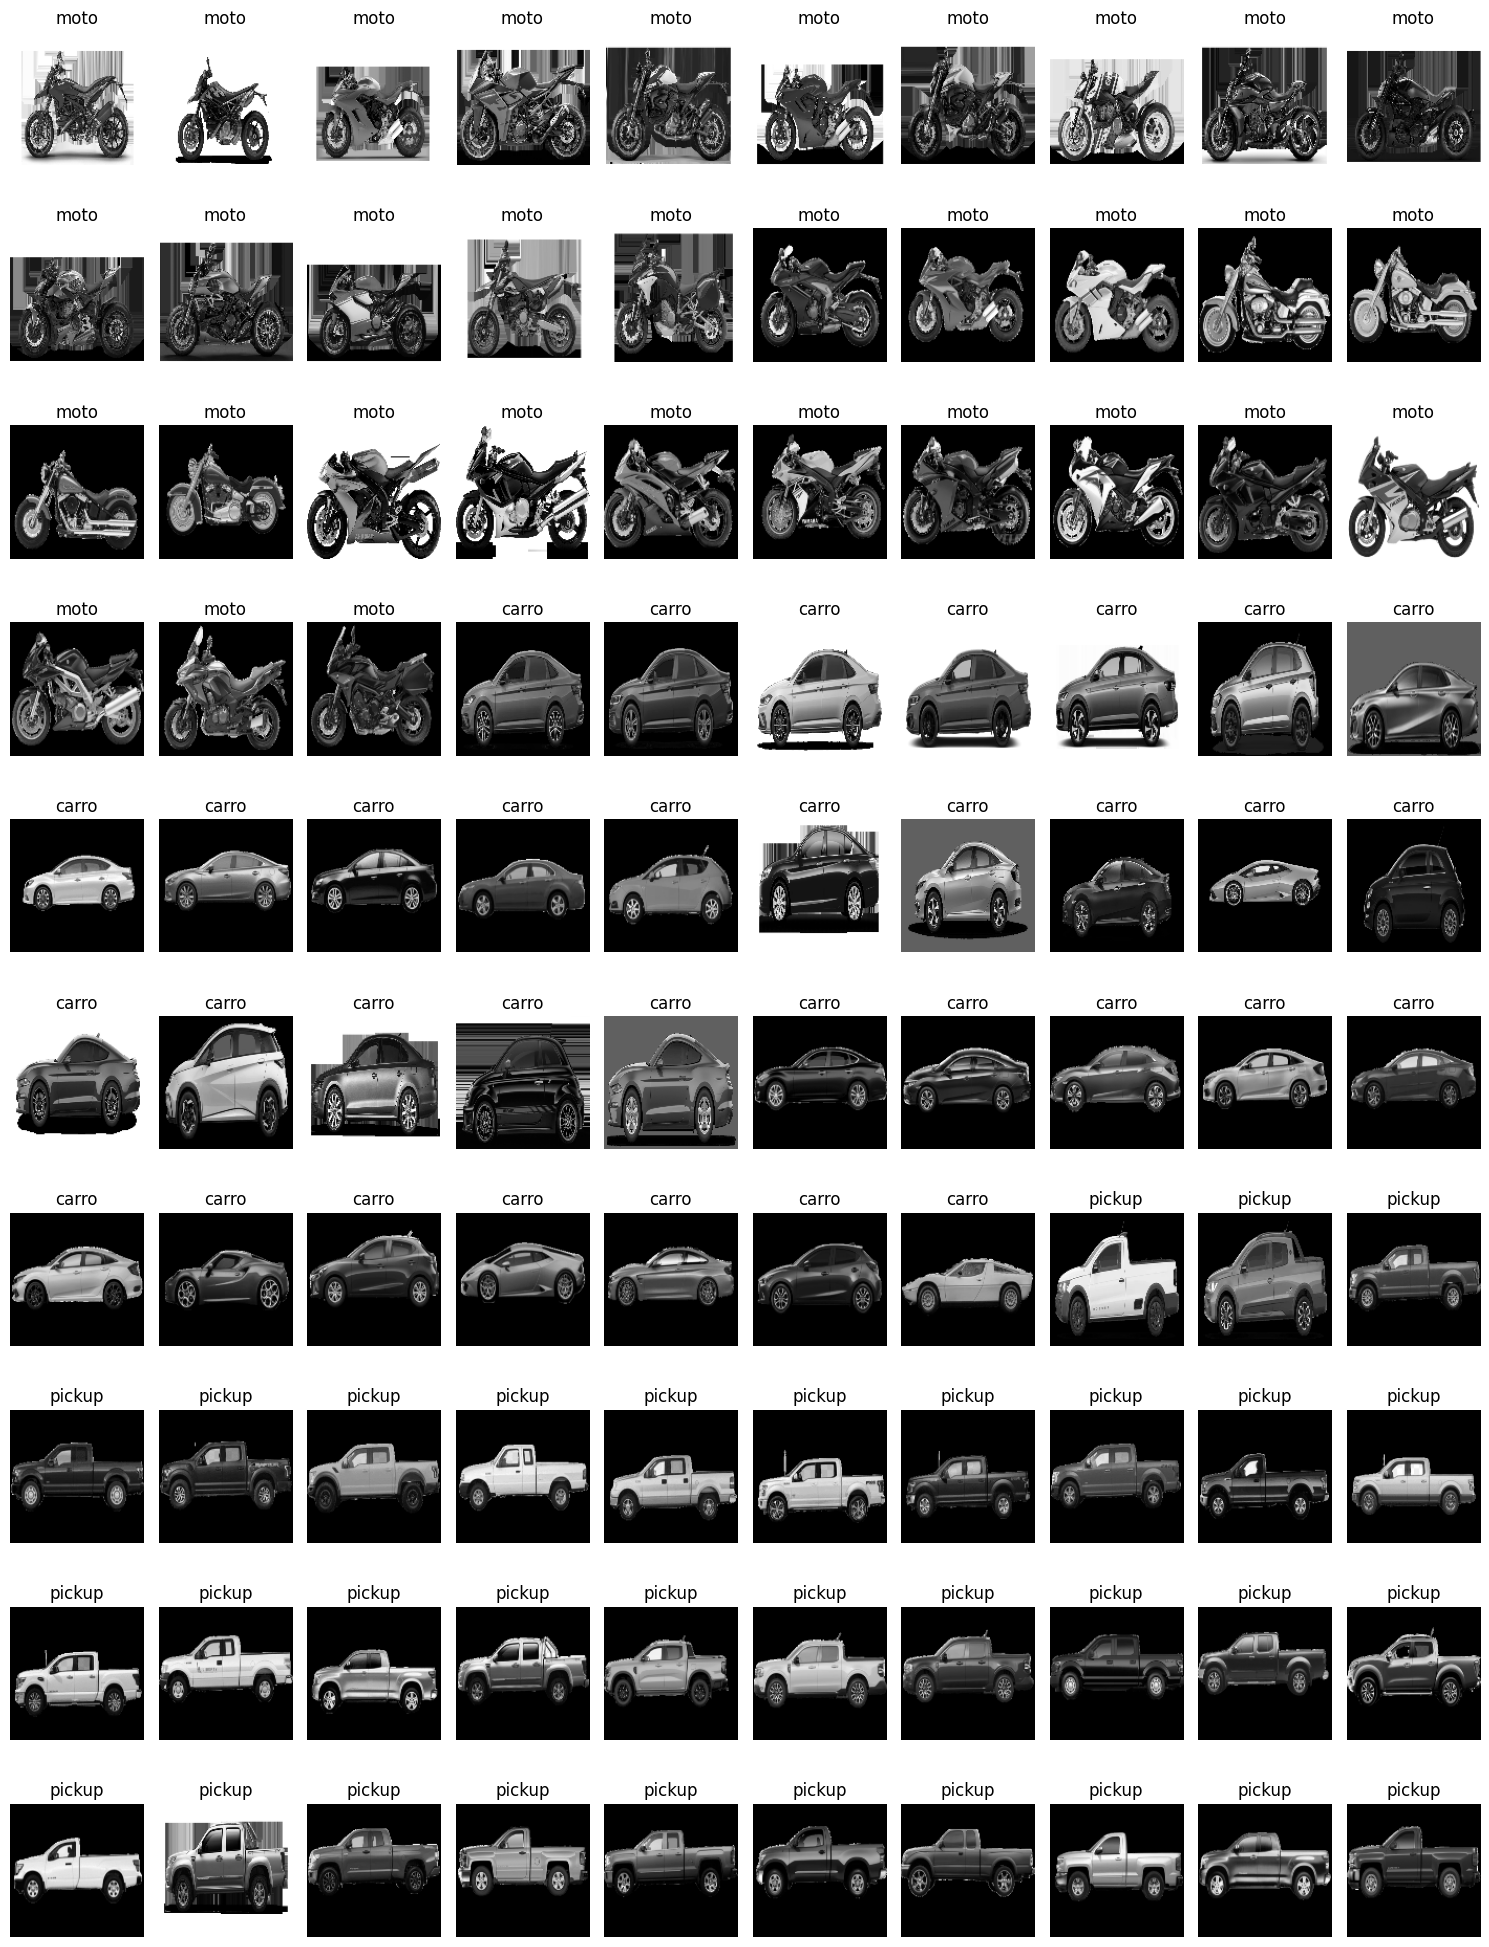

In [390]:
def graficar_imagenes_con_etiquetas(imagenes, etiquetas):

  plt.figure(figsize=(15, 20))
  for i in range(len(imagenes)):
    plt.subplot(10, 10, i + 1) # 10x10 = 100
    plt.imshow(cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB))
    plt.title(etiquetas[i])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

graficar_imagenes_con_etiquetas(X_train, y_train)

In [391]:
def normalizar(datos):
  return np.array(datos).astype(float) / 255.0

X_train =  normalizar(X_train)
X_test = normalizar(X_test)

In [392]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
df_etiquetas_encoded = pd.DataFrame({'Etiqueta Original': label_encoder.classes_, 'Etiqueta Codificada': label_encoder.transform(label_encoder.classes_)})
y_train_one_hot = to_categorical(y_train_encoded)

In [393]:
def modelo_red_neuronal_densa(input_shape=(128,128,1), num_clases= NUMERO_CLASES):
  modelo = Sequential()
  modelo.add(Flatten(input_shape=input_shape)) #capa de entrada 128x128 = 16384
  modelo.add(Dense(300, activation='relu')) #capa oculta 1: 3000
  modelo.add(Dense(128, activation='relu')) #capa oculta 2: 128
  modelo.add(Dense(num_clases, activation='softmax')) #capa oculta : 3
  return modelo

modelo = modelo_red_neuronal_densa()

modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

historial = modelo.fit(X_train, y_train_one_hot, epochs=9, batch_size=32, validation_split=0.2,verbose=1)

Epoch 1/9
3/3 [==============================] - 1s 114ms/step - loss: 5.0921 - accuracy: 0.3375 - val_loss: 3.1809 - val_accuracy: 0.4500
Epoch 2/9
3/3 [==============================] - 0s 31ms/step - loss: 1.4667 - accuracy: 0.7125 - val_loss: 4.7330 - val_accuracy: 0.1000
Epoch 3/9
3/3 [==============================] - 0s 34ms/step - loss: 1.2066 - accuracy: 0.6750 - val_loss: 4.5621 - val_accuracy: 0.2500
Epoch 4/9
3/3 [==============================] - 0s 33ms/step - loss: 1.3462 - accuracy: 0.7750 - val_loss: 5.9594 - val_accuracy: 0.1000
Epoch 5/9
3/3 [==============================] - 0s 33ms/step - loss: 0.7790 - accuracy: 0.8375 - val_loss: 4.0920 - val_accuracy: 0.3000
Epoch 6/9
3/3 [==============================] - 0s 33ms/step - loss: 0.2486 - accuracy: 0.9375 - val_loss: 4.1871 - val_accuracy: 0.3500
Epoch 7/9
3/3 [==============================] - 0s 31ms/step - loss: 0.5983 - accuracy: 0.9000 - val_loss: 4.4587 - val_accuracy: 0.2500
Epoch 8/9
3/3 [==================

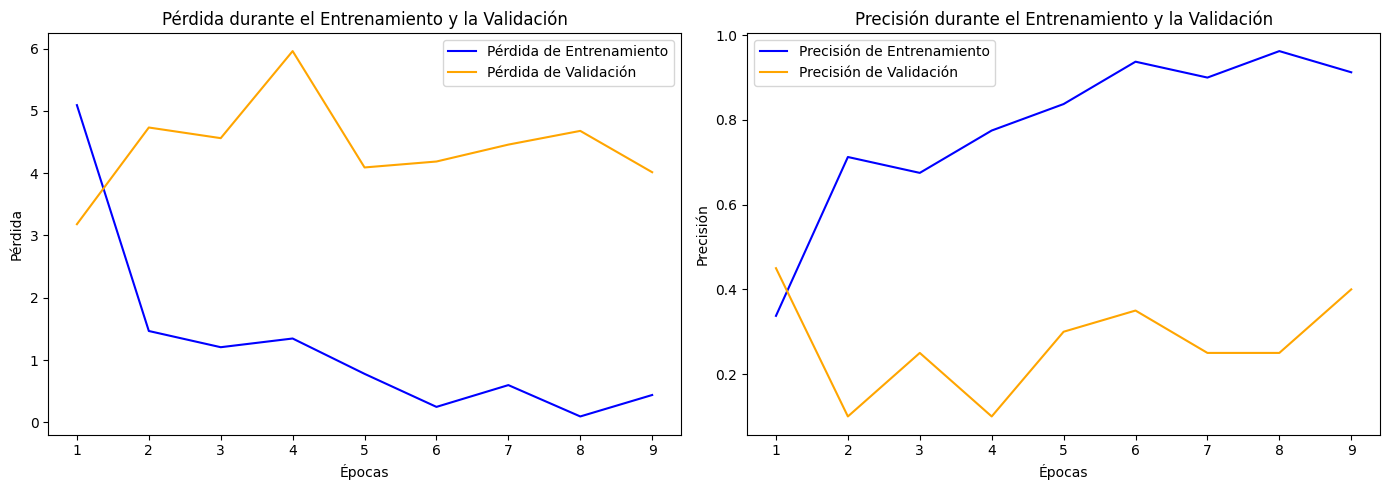

In [394]:
def graficar_historial(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)


    plt.figure(figsize=(14, 5))

    # Gráfico de la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Pérdida de Entrenamiento', color='blue')
    plt.plot(epochs, val_loss, label='Pérdida de Validación', color='orange')
    plt.title('Pérdida durante el Entrenamiento y la Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Gráfico de la precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Precisión de Entrenamiento', color='blue')
    plt.plot(epochs, val_accuracy, label='Precisión de Validación', color='orange')
    plt.title('Precisión durante el Entrenamiento y la Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
graficar_historial(historial)

In [395]:
def evaluar_modelo(modelo, X_test, y_test, label_encoder):
  loss, accuracy = modelo.evaluate(X_test, to_categorical(label_encoder.transform(y_test)), verbose=1)
  print(f"Pérdida del Modelo: {loss}")
  print(f"Precisión del Modelo: {accuracy}")

  y_pred = modelo.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  y_test_decoded = label_encoder.transform(y_test)

  print("Reporte de Clasificación:")
  print(classification_report(y_test_decoded, y_pred_classes, target_names=label_encoder.classes_))

  exactitud = accuracy_score(y_test_decoded, y_pred_classes)
  precision = precision_score(y_test_decoded, y_pred_classes, average='weighted')
  recall = recall_score(y_test_decoded, y_pred_classes, average='weighted')
  f1 = f1_score(y_test_decoded, y_pred_classes, average='weighted')

  df_metricas = ({
      'Metrica': ['Exactitud', 'Precision', 'Recall', 'F1-Score'],
      'Valor': [exactitud, precision, recall, f1]
  })

  print(f"Precisión del Modelo: {accuracy}")


  cm = confusion_matrix(y_test_decoded, y_pred_classes)
  return df_metricas, cm

df_metricas, cm = evaluar_modelo(modelo, X_test, y_test, label_encoder)

1/1 [==============================] - 0s 31ms/step - loss: 0.1969 - accuracy: 0.9500
Pérdida del Modelo: 0.19689008593559265
Precisión del Modelo: 0.949999988079071
1/1 [==============================] - 0s 60ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

       carro       0.88      1.00      0.93         7
        moto       1.00      1.00      1.00         6
      pickup       1.00      0.86      0.92         7

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

Precisión del Modelo: 0.949999988079071


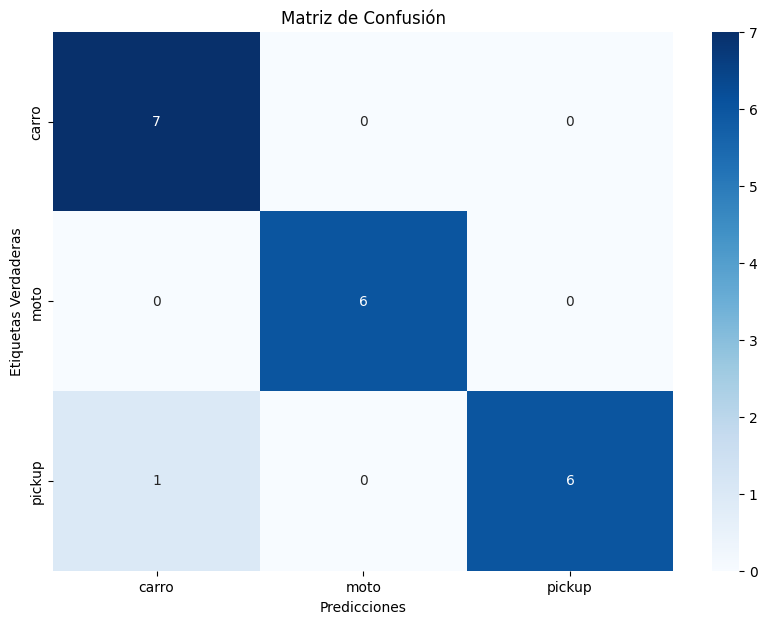

In [396]:
def graficar_matriz_confusion(cm, etiquetas):
  plt.figure(figsize=(10,7))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
  plt.xlabel('Predicciones')
  plt.ylabel('Etiquetas Verdaderas')
  plt.title('Matriz de Confusión')
  plt.show()

graficar_matriz_confusion(cm, label_encoder.classes_)

In [397]:
def validacion_cruzada(modelo, X, y_encoded, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_losses = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]


        modelo_fold = modelo_red_neuronal_densa(input_shape=(128,128,1), num_clases=NUMERO_CLASES)
        modelo_fold.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


        historial_fold = modelo_fold.fit(X_train_fold, y_train_fold, epochs=9, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)


        loss, accuracy = modelo_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_losses.append(loss)
        fold_accuracies.append(accuracy)

    return fold_losses, fold_accuracies


fold_losses, fold_accuracies = validacion_cruzada(modelo, X_train, y_train_one_hot)

# Mostrar los resultados de la validación cruzada
print(f"Pérdidas en cada pliegue: {fold_losses}")
print(f"Precisión en cada pliegue: {fold_accuracies}")
print(f"Pérdida promedio: {np.mean(fold_losses)}")
print(f"Precisión promedio: {np.mean(fold_accuracies)}")

Pérdidas en cada pliegue: [1.254649043083191, 0.14871716499328613, 0.3563913404941559, 0.7959921360015869, 2.0421319007873535]
Precisión en cada pliegue: [0.8500000238418579, 0.8999999761581421, 0.8999999761581421, 0.800000011920929, 0.8500000238418579]
Pérdida promedio: 0.9195763170719147
Precisión promedio: 0.8600000023841858


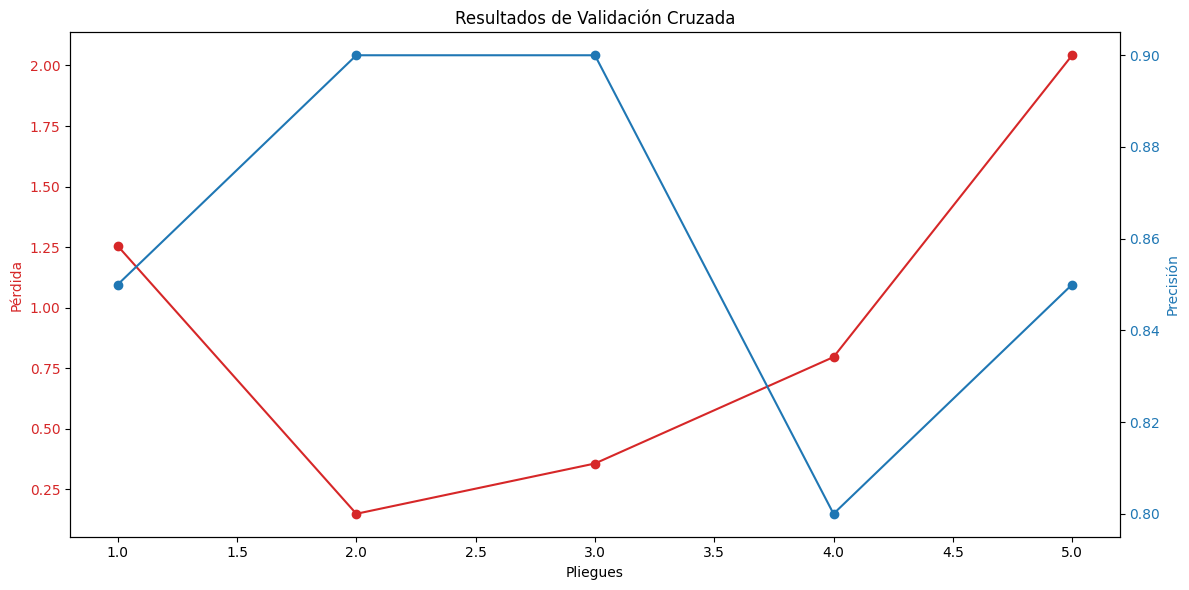

In [398]:

def graficar_resultados_kfold(fold_losses, fold_accuracies):
    # Número de pliegues
    k = len(fold_losses)
    pliegues = np.arange(1, k + 1)

    # Crear la figura y los ejes para la gráfica
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Graficar las pérdidas en cada pliegue
    ax1.set_title('Resultados de Validación Cruzada')
    ax1.set_xlabel('Pliegues')
    ax1.set_ylabel('Pérdida', color='tab:red')
    ax1.plot(pliegues, fold_losses, marker='o', color='tab:red', label='Pérdida')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Crear un segundo eje para las precisiones
    ax2 = ax1.twinx()
    ax2.set_ylabel('Precisión', color='tab:blue')
    ax2.plot(pliegues, fold_accuracies, marker='o', color='tab:blue', label='Precisión')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Agregar leyendas y mostrar la gráfica
    fig.tight_layout()
    plt.show()

# Graficar los resultados de la validación cruzada
graficar_resultados_kfold(fold_losses, fold_accuracies)


1/1 [==============================] - 0s 26ms/step
AUC Score Promedio: 0.9923076923076923


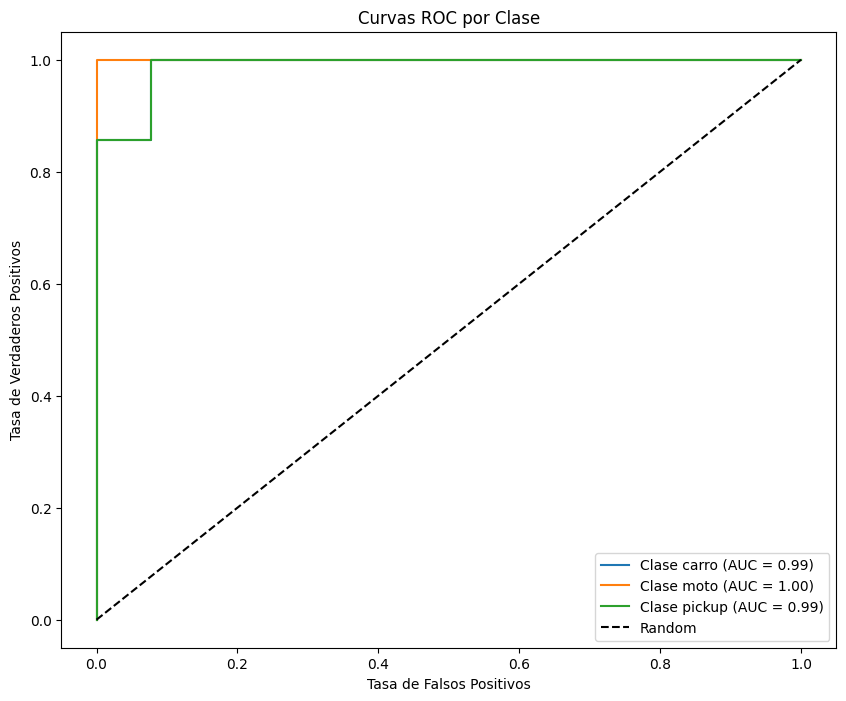

In [399]:
def calcular_roc_auc(modelo, X_test, y_test, label_encoder):
    y_test_binario = label_binarize(y_test, classes=label_encoder.classes_)
    y_pred_probabilidades = modelo.predict(X_test)

    true_positiveRate = {}
    false_positiveRate = {}
    roc_auc = {}

    for i in range(NUMERO_CLASES):
        false_positiveRate[i], true_positiveRate[i], _ = roc_curve(y_test_binario[:, i], y_pred_probabilidades[:, i])
        roc_auc[i] = auc(false_positiveRate[i], true_positiveRate[i])

    auc_score_promedio = roc_auc_score(y_test_binario, y_pred_probabilidades, average='weighted')
    return false_positiveRate, true_positiveRate, roc_auc, auc_score_promedio


false_positiveRate, true_positiveRate, roc_auc,auc_score_promedio  = calcular_roc_auc(modelo, X_test, y_test, label_encoder)

#print(false_positiveRate)
#print(true_positiveRate)
#print(roc_auc)
print(f"AUC Score Promedio: {auc_score_promedio}")

def graficar_roc_curve(false_positiveRate, true_positiveRate, roc_auc, etiquetas):
  plt.figure(figsize=(10, 8))
  for i in range(NUMERO_CLASES):
    plt.plot(false_positiveRate[i], true_positiveRate[i], label=f'Clase {etiquetas[i]} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0, 1], [0, 1], 'k--', label='Random')
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positivos')
  plt.title('Curvas ROC por Clase')
  plt.legend(loc='lower right')
  plt.show()


graficar_roc_curve(false_positiveRate, true_positiveRate, roc_auc, label_encoder.classes_)